# WZE-UAV Image Classification using Deep Learning

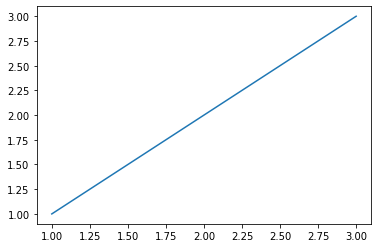

In [1]:
import os
import glob
import matplotlib.pyplot as plt
import rasterio
import numpy as np
import mlxtend
from pathlib import Path
from tqdm.auto import tqdm

x = (1,3)
y = (1,3)
plt.plot(x,y)

In [2]:
import torch
import torchvision.transforms as T
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchinfo import summary
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torchinfo import summary
import h5py

In [3]:
import wze_uav.data_loader as data_loader
import wze_uav.visualization as visualization
import wze_uav.models as models
from wze_uav.engine import *
from wze_uav.utils2 import *
from wze_uav.log_writer import create_writer

#### Get PyTorch version

In [4]:
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 1.13.1+cu116
torchvision version: 0.14.1+cu116


#### Preparing device agnostic code 

In [5]:
# ensure device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# get index of currently selected device
print(f"Index of current divice: {torch.cuda.current_device()}")
# get number of GPUs available
print(f"Number of GPUs available: {torch.cuda.device_count()}")
# get the name of the device
print(f"GPU Model: {torch.cuda.get_device_name(0)}")

cuda
Index of current divice: 0
Number of GPUs available: 1
GPU Model: Quadro RTX 8000


#### Ensure reproducibility 

In [6]:
# for more information, see also: https://pytorch.org/docs/stable/notes/randomness.html

# Set seeds
def set_seeds(seed: int=0):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

# seed for numpy
np.random.seed(0)
# avoiding non-deterministic algorithms
#torch.use_deterministic_algorithms(True)
# Set to true -> might speed up the process but should be set to False if reproducible results are desired
torch.backends.cudnn.benchmark = True


#### Define file directories

In [7]:
set_seeds() # ensure reproducibility

# Data 2020
train_data_path = r"D:\Drohnendaten\10_WZE-UAV\Auswertung_findatree\2020\ROI\rgb\train"
val_data_path = r"D:\Drohnendaten\10_WZE-UAV\Auswertung_findatree\2020\ROI\rgb\val"
test_data_path = r"D:\Drohnendaten\10_WZE-UAV\Auswertung_findatree\2020\ROI\rgb\test"

# Data 2021
train_data_path_2021 = r"D:\Drohnendaten\10_WZE-UAV\Auswertung_findatree\2021\ROI\rgb\train"
val_data_path_2021 = r"D:\Drohnendaten\10_WZE-UAV\Auswertung_findatree\2021\ROI\rgb\val"
test_data_path_2021 = r"D:\Drohnendaten\10_WZE-UAV\Auswertung_findatree\2021\ROI\rgb\test"

# Data 2022
train_data_path_2022 = r"D:\Drohnendaten\10_WZE-UAV\Auswertung_findatree\2022\ROI\rgb\train"
val_data_path_2022 = r"D:\Drohnendaten\10_WZE-UAV\Auswertung_findatree\2022\ROI\rgb\val"
test_data_path_2022 = r"D:\Drohnendaten\10_WZE-UAV\Auswertung_findatree\2022\ROI\rgb\test"



#### Load images and features (labels and tree species) from hdf5 files

In [8]:
# load all image and feature arrays from hdf5
# loops through all hdf5 files! 

# Data 2020
train_image_set_2020, train_label_set_2020, train_species_set_2020, train_kkl_set_2020, train_bk_set_2020 = data_loader.hdf5_to_img_label(train_data_path, load_sets = ["images_masked"])
val_image_set_2020, val_label_set_2020, val_species_set_2020, val_kkl_set_2020, val_bk_set_2020 = data_loader.hdf5_to_img_label(val_data_path, load_sets = ["images_masked"])
test_image_set_2020, test_label_set_2020, test_species_set_2020, test_kkl_set_2020, test_bk_set_2020 = data_loader.hdf5_to_img_label(test_data_path, load_sets = ["images_masked"])

# Data 2021
train_image_set_2021, train_label_set_2021, train_species_set_2021, train_kkl_set_2021, train_bk_set_2021 = data_loader.hdf5_to_img_label(train_data_path_2021, load_sets = ["images_masked"])
val_image_set_2021, val_label_set_2021, val_species_set_2021, val_kkl_set_2021, val_bk_set_2021 = data_loader.hdf5_to_img_label(val_data_path_2021, load_sets = ["images_masked"])
test_image_set_2021, test_label_set_2021, test_species_set_2021, test_kkl_set_2021, test_bk_set_2021 = data_loader.hdf5_to_img_label(test_data_path_2021, load_sets = ["images_masked"])

# Data 2022
train_image_set_2022, train_label_set_2022, train_species_set_2022, train_kkl_set_2022, train_bk_set_2022 = data_loader.hdf5_to_img_label(train_data_path_2022, load_sets = ["images_masked"])
val_image_set_2022, val_label_set_2022, val_species_set_2022, val_kkl_set_2022, val_bk_set_2022 = data_loader.hdf5_to_img_label(val_data_path_2022, load_sets = ["images_masked"])
test_image_set_2022, test_label_set_2022, test_species_set_2022, test_kkl_set_2022, test_bk_set_2022 = data_loader.hdf5_to_img_label(test_data_path_2022, load_sets = ["images_masked"])








In [9]:
# stack all data from 2020, 2021 and 2022 into one dataset
# images
train_image_set = np.concatenate((train_image_set_2020, train_image_set_2021, train_image_set_2022), axis=0)
val_image_set = np.concatenate((val_image_set_2020, val_image_set_2021, val_image_set_2022), axis=0)
test_image_set = np.concatenate((test_image_set_2020, test_image_set_2021, test_image_set_2022), axis=0)

#labels
train_label_set = np.concatenate((train_label_set_2020, train_label_set_2021, train_label_set_2022), axis=0)
val_label_set = np.concatenate((val_label_set_2020, val_label_set_2021, val_label_set_2022), axis=0)
test_label_set = np.concatenate((test_label_set_2020, test_label_set_2021, test_label_set_2022), axis=0)

#species
train_species_set = np.concatenate((train_species_set_2020, train_species_set_2021, train_species_set_2022), axis=0)
val_species_set = np.concatenate((val_species_set_2020, val_species_set_2021, val_species_set_2022), axis=0)
test_species_set = np.concatenate((test_species_set_2020, test_species_set_2021, test_species_set_2022), axis=0)

#kkl
train_kkl_set = np.concatenate((train_kkl_set_2020, train_kkl_set_2021, train_kkl_set_2022), axis=0)
val_kkl_set = np.concatenate((val_kkl_set_2020, val_kkl_set_2021, val_kkl_set_2022), axis=0)
test_kkl_set = np.concatenate((test_kkl_set_2020, test_kkl_set_2021, test_kkl_set_2022), axis=0)

#bk
train_bk_set = np.concatenate((train_bk_set_2020, train_bk_set_2021, train_bk_set_2022), axis=0)
val_bk_set = np.concatenate((val_bk_set_2020, val_bk_set_2021, val_bk_set_2022), axis=0)
test_bk_set = np.concatenate((test_bk_set_2020, test_bk_set_2021, test_bk_set_2022), axis=0)

In [10]:
# checking shapes and amount of samples. Image sample size should be equal to label sample size!
# Images should be of shape (n, H, W, C): n = sample size | H = image height | W = image width | C = number of bands
print("Dataset 2020")
print(f"\nTrain dataset shape: {train_image_set_2020.shape}")
print(f"Train labels shape: {train_label_set_2020.shape}")
print(f"Train species shape: {train_species_set_2020.shape}")
print(f"Train kkl shape: {train_kkl_set_2020.shape}")
print(f"Train bk shape: {train_bk_set_2020.shape}")
print("-"*50)
print(f"Validation dataset shape: {val_image_set_2020.shape}")
print(f"Validation labels shape: {val_label_set_2020.shape}")
print("-"*50)
print(f"Test dataset shape: {test_image_set_2020.shape}")
print(f"Test labels shape: {test_label_set_2020.shape}")
print("-"*50)
print(f"\nTotal image samples: {train_image_set_2020.shape[0] + val_image_set_2020.shape[0] + test_image_set_2020.shape[0]}")
print(f"Total label samples: {train_label_set_2020.shape[0] + val_label_set_2020.shape[0] + test_label_set_2020.shape[0]}\n")
print("="*50)
print("\nDataset 2021")
print(f"\nTrain dataset shape: {train_image_set_2021.shape}")
print(f"Train labels shape: {train_label_set_2021.shape}")
print("-"*50)
print(f"Validation dataset shape: {val_image_set_2021.shape}")
print(f"Validation labels shape: {val_label_set_2021.shape}")
print("-"*50)
print(f"Test dataset shape: {test_image_set_2021.shape}")
print(f"Test labels shape: {test_label_set_2021.shape}")
print("-"*50)
print(f"\nTotal image samples: {train_image_set_2021.shape[0] + val_image_set_2021.shape[0] + test_image_set_2021.shape[0]}")
print(f"Total label samples: {train_label_set_2021.shape[0] + val_label_set_2021.shape[0] + test_label_set_2021.shape[0]}\n")
print("="*50)
print("\nDataset 2022")
print(f"\nTrain dataset shape: {train_image_set_2022.shape}")
print(f"Train labels shape: {train_label_set_2022.shape}")
print("-"*50)
print(f"Validation dataset shape: {val_image_set_2022.shape}")
print(f"Validation labels shape: {val_label_set_2022.shape}")
print("-"*50)
print(f"Test dataset shape: {test_image_set_2022.shape}")
print(f"Test labels shape: {test_label_set_2022.shape}")
print("-"*50)
print(f"\nTotal image samples: {train_image_set_2022.shape[0] + val_image_set_2022.shape[0] + test_image_set_2022.shape[0]}")
print(f"Total label samples: {train_label_set_2022.shape[0] + val_label_set_2022.shape[0] + test_label_set_2022.shape[0]}\n")
print("="*50)
print("\nStacked Dataset")
print(f"\nTrain dataset shape: {train_image_set.shape}")
print(f"Train labels shape: {train_label_set.shape}")
print("-"*50)
print(f"Validation dataset shape: {val_image_set.shape}")
print(f"Validation labels shape: {val_label_set.shape}")
print("-"*50)
print(f"Test dataset shape: {test_image_set.shape}")
print(f"Test labels shape: {test_label_set.shape}")
print("-"*50)
print(f"\nTotal image samples: {train_image_set.shape[0] + val_image_set.shape[0] + test_image_set.shape[0]}")
print(f"Total label samples: {train_label_set.shape[0] + val_label_set.shape[0] + test_label_set.shape[0]}\n")

Dataset 2020

Train dataset shape: (4886, 250, 250, 3)
Train labels shape: (4886, 1)
Train species shape: (4886, 1)
Train kkl shape: (4886, 1)
Train bk shape: (4886, 1)
--------------------------------------------------
Validation dataset shape: (1053, 250, 250, 3)
Validation labels shape: (1053, 1)
--------------------------------------------------
Test dataset shape: (917, 250, 250, 3)
Test labels shape: (917, 1)
--------------------------------------------------

Total image samples: 6856
Total label samples: 6856


Dataset 2021

Train dataset shape: (4505, 250, 250, 3)
Train labels shape: (4505, 1)
--------------------------------------------------
Validation dataset shape: (1053, 250, 250, 3)
Validation labels shape: (1053, 1)
--------------------------------------------------
Test dataset shape: (877, 250, 250, 3)
Test labels shape: (877, 1)
--------------------------------------------------

Total image samples: 6435
Total label samples: 6435


Dataset 2022

Train dataset shape:

#### Create PyTorch Datasets (converts ndarrays into tensors)

In [11]:
# train transform with augmentation. 
transform_train = transforms.Compose([transforms.ToTensor(),
                                      #transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      #                     std=[0.229, 0.224, 0.225]),
                                      transforms.ColorJitter(brightness=(0.5,1.5), contrast=(0.5,1.2), saturation=(0.5,1.2), hue=(-0.05,0.05)),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.RandomVerticalFlip(p=0.5),
                                      transforms.RandomRotation(degrees=[-90,90]),
                                      #transforms.Resize(224)
                                      ])

# test and val dataset transform without augmentation. 
transform = transforms.Compose([transforms.ToTensor(),
                                #transforms.Resize(224)
                               ])

class_idx = {'healthy':0,'stressed':1, 'dead':2}

# class names need to fit the customDataset class used e.g. 3 classes -> use CustomDataset3Classes
#class_names = ['healthy', 'slightly_stressed', 'moderately_stressed', 'highly_stressed', 'dead']
class_names = ['healthy', 'moderately_stressed', 'highly_stressed', 'dead']
#class_names = ['healthy', 'stressed', 'dead']

# choose custom dataset loader with 3 - 5 classes
train_dataset = data_loader.CustomDataset4Classes(
    data = train_image_set,
    labels = train_label_set,
    class_names=class_names,
    class_idx=class_idx, 
    species = train_species_set,
    kkl = train_kkl_set,
    transform=transform_train
)

val_dataset = data_loader.CustomDataset4Classes(
    data = val_image_set,
    labels = val_label_set,
    class_names=class_names,
    class_idx=class_idx, 
    species = val_species_set,
    kkl = val_kkl_set,
    transform=transform
)

test_dataset = data_loader.CustomDataset4Classes(
    data = test_image_set,
    labels = test_label_set,
    class_names=class_names,
    class_idx=class_idx, 
    species = test_species_set,
    kkl = test_kkl_set,
    transform=transform
)



In [12]:
from typing import Dict, List, Tuple
import torch
import random
import matplotlib.pyplot as plt

def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[int] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(30, 20))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label, targ_species, targ_kkl = dataset[targ_sample][0], dataset[targ_sample][1], dataset.species[targ_sample], dataset.kkl[targ_sample]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(2, 1, 0)
        #targ_image_adjust = 
 

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_species}"
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

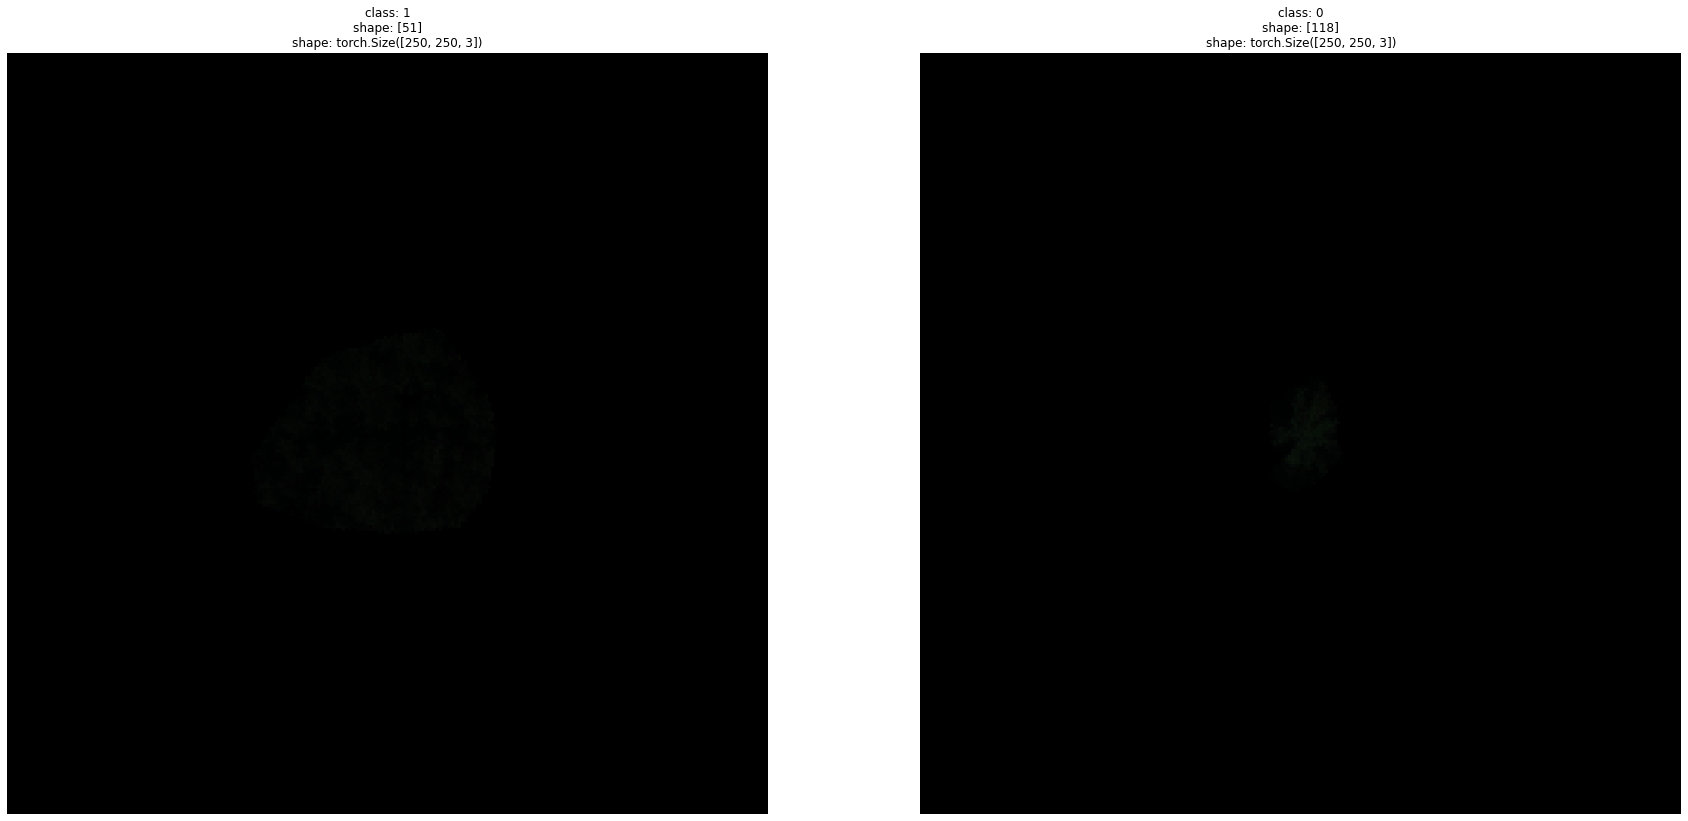

In [13]:
display_random_images(train_dataset, 
                      n=2, 
                      classes=[0, 1, 2],
                      seed=None)
#train_dataset[0][0].dtype

In [14]:
img, label = test_dataset[0]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Image shape: torch.Size([3, 250, 250])
Image datatype: torch.float32
Image label: 2
Label datatype: <class 'int'>


#### Create PyTorch Dataloaders

In [15]:
# set seeds
g = torch.Generator()
g.manual_seed(0)
NUM_WORKERS=3
batch_size=32

train_dataloader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              persistent_workers=True,
                              pin_memory=True,
                              num_workers=NUM_WORKERS,
                              #worker_init_fn=seed_worker, 
                              generator=g,
                              shuffle=True,
                              drop_last=True)

val_dataloader = DataLoader(val_dataset,
                             batch_size=batch_size,
                             persistent_workers=True,
                             pin_memory=True,
                             num_workers=NUM_WORKERS,
                             shuffle=False,
                             drop_last=True)

test_dataloader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             persistent_workers=True,
                             pin_memory=True,
                             num_workers=NUM_WORKERS,
                             shuffle=False,
                             drop_last=True)

print(len(train_dataloader))
print(len(val_dataloader))
print(len(test_dataloader))

419
90
78


In [16]:
classes = train_dataset.class_names
output_shape = len(classes)
print(output_shape)



4


In [17]:
def create_effnetb0(output_shape: int, unfreeze: bool, device: torch.device):
    # 1. Get the base model with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    
    # get the transforms used to create the pretrained weights
    auto_transforms = weights.transforms()
    
    # define model
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)
    
    # 2. Freeze/unfreeze the base model layers
    for param in model.parameters():
        param.requires_grad = unfreeze
        
    # 3. Set seeds
    set_seeds()
    
    # 4. Change the classifier head
    model.classifier = torch.nn.Sequential(torch.nn.Dropout(p=0.2, inplace=True),
                                           torch.nn.Linear(in_features=1280, # 2048 (b5), 2560 (b7)
                                                           out_features=output_shape, # same number of output units as our number of classes
                                                           bias=True)).to(device)

    # 5. Give the model a name
    model.name = "effnet_b0"
    
    print(f"[INFO] Created new {model.name} model.")
    return model

In [18]:
# Print out model summary
effnet_b0 = create_effnetb0(output_shape=output_shape, unfreeze=False, device=device)

summary(effnet_b0, 
        input_size=(64, 3, 250, 250), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=17,
        row_settings=["var_names"])

[INFO] Created new effnet_b0 model.


Layer (type (var_name))                                      Input Shape       Output Shape      Param #           Trainable
EfficientNet (EfficientNet)                                  [64, 3, 250, 250] [64, 4]           --                Partial
├─Sequential (features)                                      [64, 3, 250, 250] [64, 1280, 8, 8]  --                False
│    └─Conv2dNormActivation (0)                              [64, 3, 250, 250] [64, 32, 125, 125] --                False
│    │    └─Conv2d (0)                                       [64, 3, 250, 250] [64, 32, 125, 125] (864)             False
│    │    └─BatchNorm2d (1)                                  [64, 32, 125, 125] [64, 32, 125, 125] (64)              False
│    │    └─SiLU (2)                                         [64, 32, 125, 125] [64, 32, 125, 125] --                --
│    └─Sequential (1)                                        [64, 32, 125, 125] [64, 16, 125, 125] --                False
│    │    └─MBConv (0

In [23]:
# 1. Create epochs list
num_epochs = [50]

# 2. Create models list (need to create a new model for each experiment)
models_list = ["effnet_b0", "effnet_b7"]

#set_train_dataloader = train_dataloader

# 3. Create dataloaders dictionary for various dataloaders
train_dataloaders = {#"train_data_5_percent": train_dataloader_05,
                     #"train_data_10_percent": train_dataloader_10,
                     "train_data_100_percent": train_dataloader}

# 4. Create dataloaders dictionary for various dataloaders
val_dataloaders = {#"test_data_5_percent": test_dataloader_05,
                     #"test_data_10_percent": test_dataloader_10,
                     "test_data_100_percent": test_dataloader}

# 5. Create target folder name were to save the tensorboard event files
target_dir = "log_test"

# class imbalance where nbv 99 == dead!
#loss_weight = torch.Tensor([3730, 7632, 6578, 553, 312]) # 5 classes
loss_weight = torch.Tensor([11362, 6578, 553, 312]) # 4 classes
#loss_weight = torch.Tensor([11362, 7131, 312])# 3 classes

#for 5 classes: 
# data 2020: [1194, 2516, 2776, 261, 109]
# data 2021: [1097, 2548, 2475, 201, 114]
# data 2022: [1439, 2568, 1327, 91, 89]

loss_weight = loss_weight.type(torch.FloatTensor)
loss_weight = loss_weight.to(device)

In [ ]:
%%time
###### define Parameters######
from efficientnet import model #for custom effnet
n_bands = 3 # define number of bands
num_classes = len(classes)
lr = 0.001 # define learning rate

# 1. Set the random seeds
set_seeds(seed=0)

# 2. Keep track of experiment numbers
experiment_number = 0

# 3. Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():

    # 4. Loop through each number of epochs
    for epochs in num_epochs: 

        # 5. Loop through each model name and create a new model based on the name
        for model_name in models_list:

            # 6. Create information print outs
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")  

            # 7. Select the model
            #if model_name == "effnet_b0_custom":
                #model = model.EfficientNet.from_pretrained('efficientnet-b0', in_channels=n_bands, num_classes=num_classes, dropout_rate=0.2)
            if model_name == "effnet_b0":
                model = models.create_effnetb0(output_shape=num_classes, unfreeze=True, device=device) # creates a new model each time (important because we want each experiment to start from scratch)
            else:
                model = models.create_effnetb7(output_shape=num_classes, unfreeze=True, device=device) # creates a new model each time (important because we want each experiment to start from scratch)
            
            # 8. Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss(weight=loss_weight)
            optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

            # 9. Train target model with target dataloaders and track experiments
            results = train(model=model,
                            n_bands=n_bands,
                            batch_size=batch_size,
                            train_dataloader=train_dataloader,
                            test_dataloader=val_dataloader, 
                            optimizer=optimizer,
                            loss_fn=loss_fn,
                            num_classes=num_classes,
                            epochs=epochs,
                            device=device,
                            writer=create_writer(target_dir=target_dir,
                                                 experiment_name=dataloader_name,
                                                 model_name=model_name,
                                                 extra=f"{epochs}_epochs"))
            
            # 10. Save the model to file so we can get back the best model
            save_filepath = f"01_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: effnet_b0
[INFO] DataLoader: train_data_100_percent
[INFO] Number of epochs: 50
[INFO] Created new effnet_b0 model.
[INFO] Created SummaryWriter, saving to: log_test\2023-03\train_data_100_percent\effnet_b0\50_epochs...


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 
Train loss: 0.6008 | Train precision: 0.4245 | Train recall: 0.5851 | Train f1score: 0.4606 
Test loss: 0.5644 | Test precision: 0.6250 | Test recall: 0.5271 | Test f1score: 0.5332 

Epoch: 2 
Train loss: 0.5719 | Train precision: 0.4502 | Train recall: 0.5918 | Train f1score: 0.4650 
Test loss: 0.5641 | Test precision: 0.6233 | Test recall: 0.4995 | Test f1score: 0.5219 

Epoch: 3 
Train loss: 0.5672 | Train precision: 0.4743 | Train recall: 0.5954 | Train f1score: 0.4774 
Test loss: 0.5786 | Test precision: 0.6233 | Test recall: 0.4567 | Test f1score: 0.5164 

Epoch: 4 
Train loss: 0.5646 | Train precision: 0.4944 | Train recall: 0.5970 | Train f1score: 0.4818 
Test loss: 0.5597 | Test precision: 0.6215 | Test recall: 0.6108 | Test f1score: 0.5499 

Epoch: 5 
Train loss: 0.5574 | Train precision: 0.5217 | Train recall: 0.6002 | Train f1score: 0.4883 
Test loss: 0.5795 | Test precision: 0.6250 | Test recall: 0.4782 | Test f1score: 0.5198 

Epoch: 6 
Train loss: 0.5593 | Trai

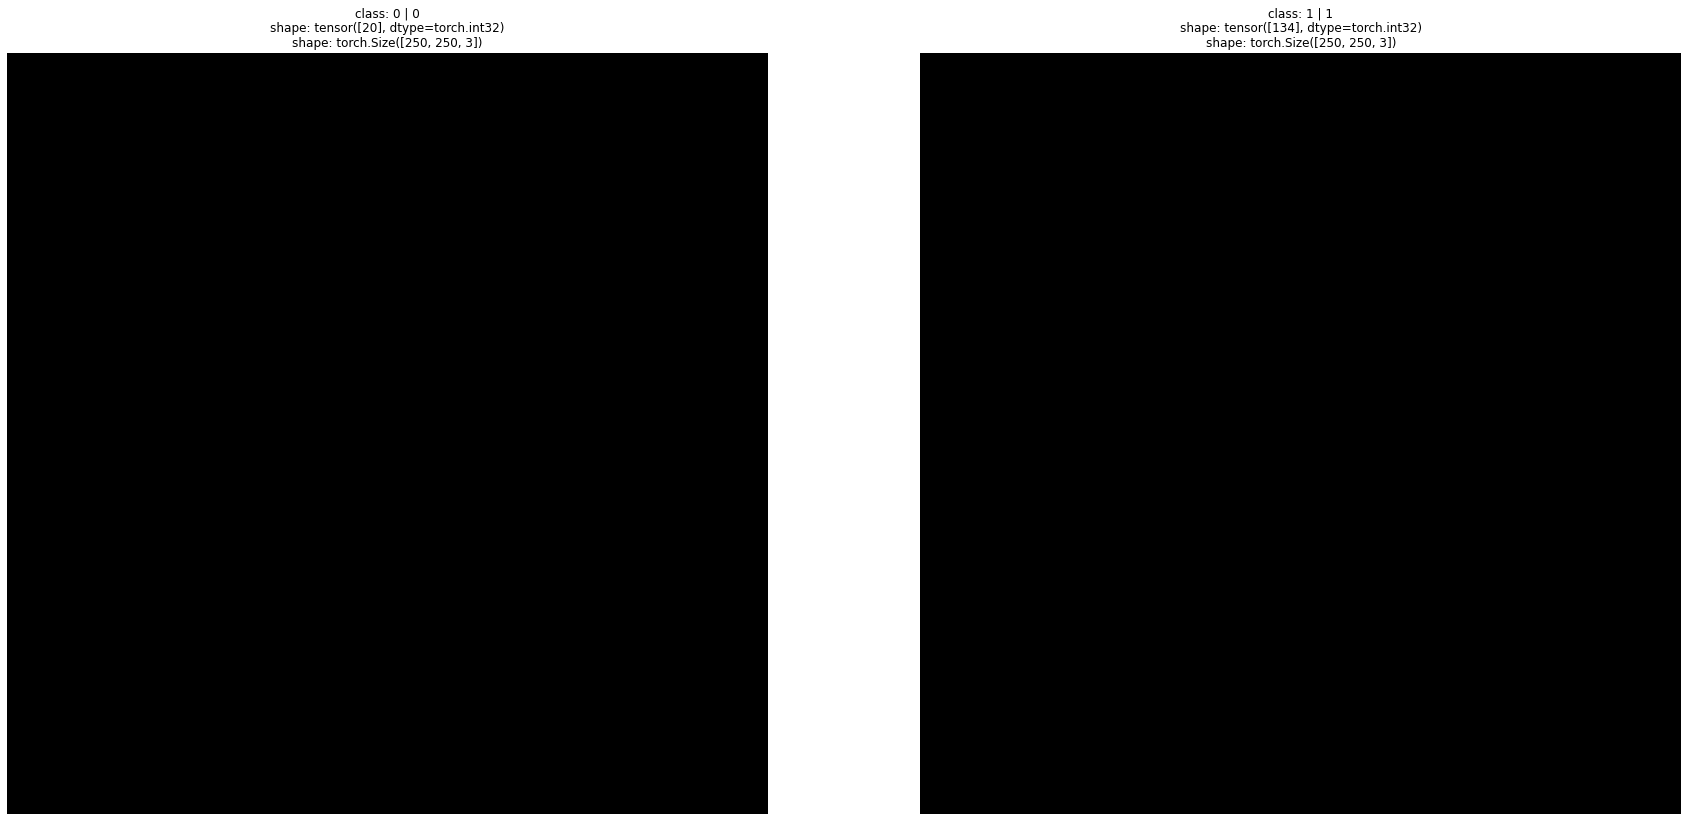

In [21]:
visualization.display_random_images(train_dataset, 
                      n=2, 
                      classes=[0, 1, 2, 3, 4],
                      seed=None)

In [10]:
rois, params_rois = exporter.export_rois(
    channels=channels,
    params_channels=params_channels,
    crowns=crowns_human,
    params_crowns=params_crowns_human,
    params_export=params_export,
    )


#exporter.rois_to_hdf5_v2(rois, params_rois, crowns, params_crowns, dir_name=r"")

#data_list = os.listdir(test_labels_path)
#data, params_data = io.load_hdf5(test_labels_path + "\\" + data_list[0])

NameError: name 'transformations' is not defined

In [63]:
params_data

{'channels': {'affine': array([[ 2.000000e-01,  0.000000e+00,  5.959600e+05],
         [ 0.000000e+00, -2.000000e-01,  5.244788e+06],
         [ 0.000000e+00,  0.000000e+00,  1.000000e+00]]),
  'crs': 'EPSG:25832',
  'date_time': '230302-144013',
  'downscale': 0,
  'max_ratio_blue': 0.0,
  'max_ratio_green': 0.0,
  'max_ratio_nir': 0.0,
  'max_ratio_re': 0.0,
  'max_ratio_red': 0.0,
  'path_dsm': 'D:\\Drohnendaten\\10_WZE-UAV\\Auswertung_findatree\\2020\\WZE-UAV-2020_DSM\\Tnr_11_D-20200909_DSM_highRMSE.tif',
  'path_dtm': 'D:\\Drohnendaten\\10_WZE-UAV\\Auswertung_findatree\\2020\\DTM_v2\\Tnr_11_D20200909_DTM.tif',
  'path_ortho': 'D:\\Drohnendaten\\10_WZE-UAV\\Auswertung_findatree\\2020\\WZE-UAV-2020_Ortho\\Tnr_11_D-20200909_Ortho_highRMSE.tif',
  'path_shapes': 'D:\\Drohnendaten\\10_WZE-UAV\\Auswertung_findatree\\2020\\Kronen\\Tnr_11_Kr.shp',
  'px_width': 0.2,
  'px_width_reproject': 0.2,
  'shape': array([1624, 1617]),
  'tnr': '11'},
 'crowns_human': {'affine': array([[ 2.000000e-

In [17]:
dataloader = DataLoader(test_dataset, batch_size=32)

In [36]:
image, label = dataset[0][0], dataset[0][1]
print(image.shape)
print(label.shape)
print(dataset.data.shape)
print(dataset.labels.shape)
print(len(dataset))
print(len(dataloader))
#print(image)
#print (label)

torch.Size([3, 300, 300])
torch.Size([1])
(5427, 300, 300, 3)
torch.Size([5427, 1])
5427
170


170